In [1]:
import pandas as pd
import os
import json
from dotenv import load_dotenv
import importlib

load_dotenv()

True

# A Graph RAG Approach to Query-Focused Summarization
<hr>


Reference: [From Local to Global: A Graph RAG Approach to Query-Focused Summarization](https://arxiv.org/abs/2404.16130)
<br>

![image](../.resources/Query-Focused-Summarization.png)


<br>
<br>
<hr>

## 1 Source Document -> Text Chunks

The chunk size used for this implementation is 600 tokens. According to the paper, using a longer chunk size can reduce the number of LLM calls required for extraction. However, this approach can lead to recall degradation, as the model may not fully extract all relevant information from a longer context window.

In [7]:
# load data
data = ""

with open("../doc/pg24022.txt", 'r') as file:
    data = '\n'.join(file.readlines())

print(data[:600])

The Project Gutenberg eBook of A Christmas Carol

    

This ebook is for the use of anyone anywhere in the United States and

most other parts of the world at no cost and with almost no restrictions

whatsoever. You may copy it, give it away or re-use it under the terms

of the Project Gutenberg License included with this ebook or online

at www.gutenberg.org. If you are not located in the United States,

you will have to check the laws of the country where you are located

before using this eBook.



Title: A Christmas Carol



Author: Charles Dickens



Illustrator: Arthur Rackham



Relea


In [8]:
from text_splitter import TextSplitter
text_splitter = TextSplitter(600, 20)

chunks = text_splitter.split_text(data)
len(chunks)

80

<hr>
<br>



## 2 Text extraction -> Element Instances

A multipart LLM prompt will be used to identify all the *entites* in the text, including their names, type and description. Then extracting *relationship* between entities

In [9]:
from extractor import GraphExtractor
from LLM import GeminiModel

ge = GraphExtractor(GeminiModel("gemini-1.5-flash-001"))

In [10]:
print(ge.extract_text(chunks[0], store=False))

From the above *entities* and *relationships* extraction using Gemini model. The model is capable of extracting and building information for entities and relationship. 

However, through many tests, the results are not consistent. Sometimes, the model fails to fully extract entities or relationships from text. This has been mentioned in paper, where the author use multiple rounds of “gleanings” to encourage the LLM to detect any additional entities it may have missed on prior extraction rounds.  

**NOTE**: Currently, the function has not included the aboved multi-gleaning process.

In [ ]:
# Extract entities and relationships from all chunks
for chunk in chunks:
    ge.extract_text(chunk)

In [ ]:
# Scrooge is the main character of Christmas Carol
ge.temp['"ENTITY"<TD>EBENEZER SCROOGE<TD>PERSON']

['Ebenezer Scrooge is the main character of "A Christmas Carol" by Charles Dickens',
 'Ebenezer Scrooge is a grasping, covetous old man, the surviving partner of the firm of Scrooge and Marley',
 'Ebenezer Scrooge is a miserly man who is visited by the ghost of Jacob Marley.  He is visited by three spirits on Christmas Eve to show him the errors of his ways',
 'Ebenezer Scrooge is the protagonist of the story, a miserly and cynical man who is visited by three spirits to learn about the consequences of his actions']

In [ ]:
# save temp information

json_temp_path = "../json/christmas_carol_temp.json"

with open(json_temp_path, "w") as fp:
    json.dump(ge.temp, fp)

<hr>
<br>

## 3 Element Instances -> Element Summaries

In second phrase of dataflow from [Microsoft GraphRAG](https://microsoft.github.io/graphrag/posts/index/1-default_dataflow/). After retrieving all the *entities* and *relationships* from list of chunks, we will merge a the entity with the same *name* and *type*, generate list of *description*. This also applies for *relationship* by merging any relationship that have the same pair of *source* and *target*.

After that, for every merged node, a LLM will be used to summarize list of description into a single description, covers full information of the node.

In [2]:
from extractor import GraphExtractor
from LLM import GeminiModel

ge = GraphExtractor(GeminiModel("gemini-1.5-flash-001"))

json_temp_path = "../json/christmas_carol_temp.json"

with open(json_temp_path, "r") as fp:
    ge.temp = json.load(fp)

In [ ]:
# Call summarize function to merge duplicated entity and relationship

# Cooldown is set to 5 seconds to prevent "429 resource exhausted" error from google client
ge.summarize(cooldown=5)

In [4]:
ge.data[:5]

[{'entity_name': 'PROJECT GUTENBERG',
  'entity_type': 'ORGANIZATION',
  'description': 'Project Gutenberg is a non-profit organization dedicated to promoting free access to electronic works. It creates and distributes free eBooks online in formats readable by a wide variety of computers. Project Gutenberg digitizes and distributes works in the public domain and works with copyright holders to make their works available to the public. It holds a copyright on the compilation of its works and is associated with the Project Gutenberg Literary Archive Foundation. The organization relies on donations and volunteers to continue its mission. \n'},
 {'entity_name': 'CHARLES DICKENS',
  'entity_type': 'PERSON',
  'description': 'Charles Dickens is the author of A Christmas Carol'},
 {'entity_name': 'ARTHUR RACKHAM',
  'entity_type': 'PERSON',
  'description': 'Arthur Rackham is an illustrator known for his illustrations for "A Christmas Carol" and other classic books'},
 {'entity_name': 'J. B. 

In [5]:
# Save to JSON file
json_path = "../json/christmas_carol.json"
ge.save_data(json_path)

File is successfully saved at: ../json/christmas_carol.json


<hr>

<br>

## 4 Element Summaries -> Graph Communities

After thrid step, we can form a usable graph with summarized *entities* and *relationships*. However, in order to provide stronger connection between entity and more efficient when searching, a community detection algorithm will be use to partition the graph into communities of nodes.

Each community has to preserve 2 aspect: **Mutually Exclusive** and **Collectively Exhautive**, which means a single node must belong to only one community.

In this stage, **Hierarchical Leiden Algorithm** is used to generate a hierarchical of entity communities

In [2]:
from langchain_community.graphs import Neo4jGraph

NEO4J_URL = os.getenv('NEO4J_URL')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
NEO4J_DATABASE = os.getenv('NEO4J_DATABASE')

kg = Neo4jGraph(NEO4J_URL, NEO4J_USERNAME, NEO4J_PASSWORD, NEO4J_DATABASE)

In [3]:
import cypher_query as cq
importlib.reload(cq)

<module 'cypher_query' from '/home/nguyen/Project/Project - RAG/v3/cypher_query.py'>

In [4]:
# Reset database
query1 = """
MATCH (a)-[r]->()
DETACH DELETE a, r
"""

query2 = """
MATCH (a)
DETACH DELETE a
"""

kg.query(query1)
kg.query(query2)

[]

In [5]:
# store json in to graph
json_path = "../json/christmas_carol.json"
with open(json_path, 'r') as fp:
    data = json.load(fp)

for dt in data:
    if "entity_name" in dt.keys():
        cq.create_entity(kg, dt["entity_name"], dt["entity_type"], dt["description"])
    else:
        cq.create_relationship(kg, dt["source_entity"], dt["target_entity"], dt["description"])

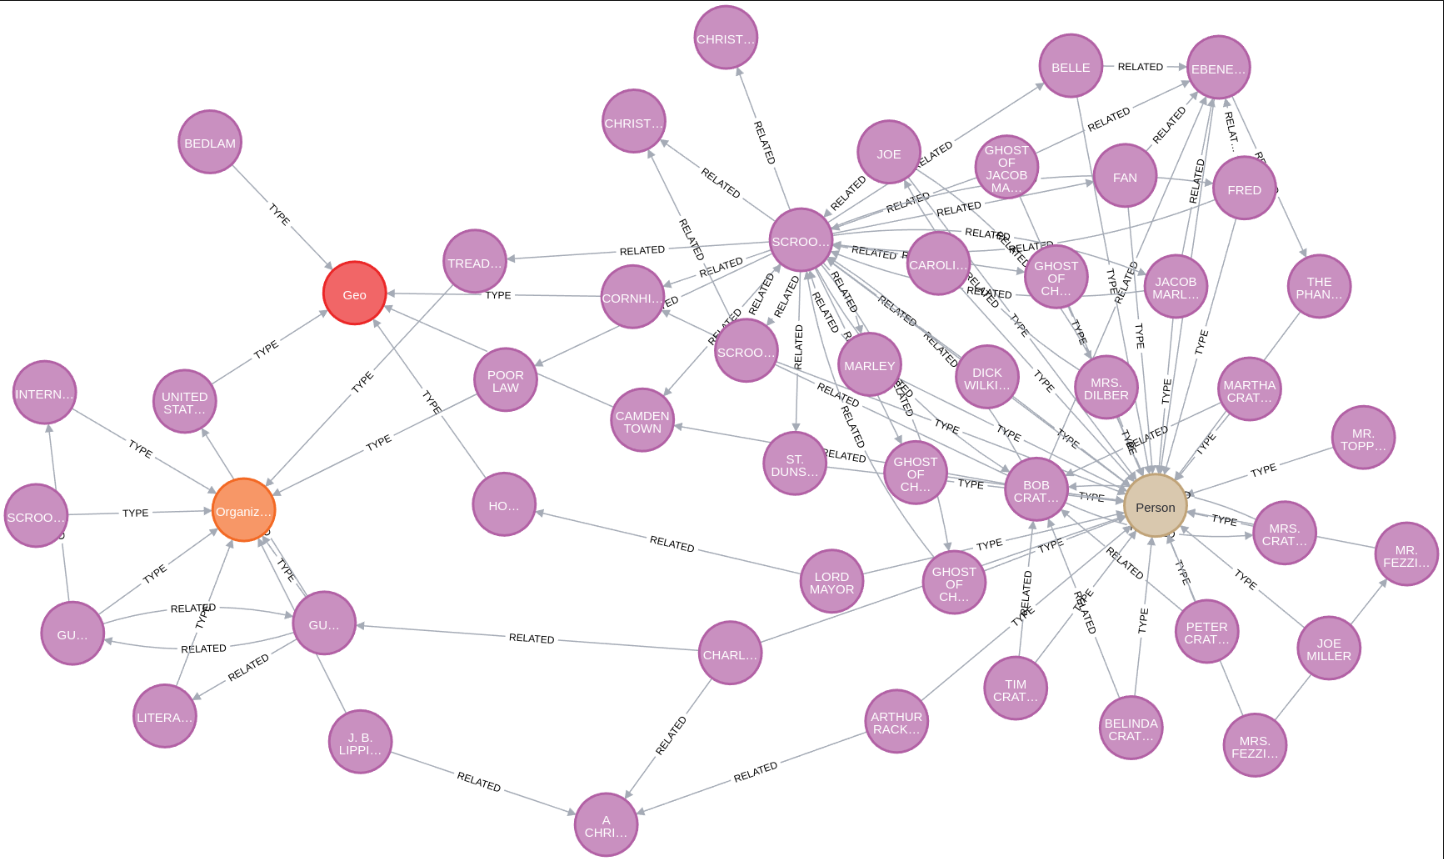

- The purple presents Entity node, while others present entity type.

- Each **RELATED** relationship between entity has a description describing the relationship between 2 entities.

In cypher, in order to perfrom graph embedding and community detection, we have to project the graph

In [6]:
graph_name = "christmas_carol"

In [ ]:
query = f"""
CALL gds.graph.drop("{graph_name}", false)
"""

# Drop any existing graph having the same name with graph name
kg.query(query)

In [8]:
# https://neo4j.com/docs/graph-data-science/current/management-ops/graph-creation/graph-project/

query = f"""
CALL gds.graph.project(
    "{graph_name}",
    ["Entity"],
    {{
        RELATED: {{orientation: "UNDIRECTED"}}
    }}
)
"""

kg.query(query)

[{'nodeProjection': {'Entity': {'label': 'Entity', 'properties': {}}},
  'relationshipProjection': {'RELATED': {'aggregation': 'DEFAULT',
    'orientation': 'UNDIRECTED',
    'indexInverse': False,
    'properties': {},
    'type': 'RELATED'}},
  'graphName': 'christmas_carol',
  'nodeCount': 105,
  'relationshipCount': 270,
  'projectMillis': 8}]

The projected graph only contains Entity nodes and the relationships betwwen entities are undirected

### **Node2Vec Graph Embedding**
embedding dim = 128

In [9]:
query = f"""
CALL gds.node2vec.stream(
    "{graph_name}"
)
YIELD nodeId, embedding
RETURN gds.util.asNode(nodeId).name AS name, embedding
"""

# Only print first 10 values of embedding array
res = kg.query(query)[0]
print(f"Name: {res['name']}\nEmbedding: {res['embedding'][:10]}")

Name: PROJECT GUTENBERG
Embedding: [0.02921578846871853, 0.23991276323795319, 0.11681374907493591, -0.03397374972701073, -0.20490705966949463, -0.10257968306541443, -0.5880280137062073, 0.20468437671661377, 0.11981715261936188, -0.13441352546215057]


### Community detection using **Leiden Algorithm**

In [10]:
query = f"""
CALL gds.leiden.stream(
    "{graph_name}",
    {{
        includeIntermediateCommunities: false
    }}
)
YIELD nodeId, communityId
RETURN gds.util.asNode(nodeId).name AS name, communityId
"""

kg.query(query)[:5]

[{'name': 'PROJECT GUTENBERG', 'communityId': 28},
 {'name': 'JOE MILLER', 'communityId': 27},
 {'name': 'UNITED STATES', 'communityId': 28},
 {'name': 'CHARLES DICKENS', 'communityId': 28},
 {'name': 'ARTHUR RACKHAM', 'communityId': 28}]

In [11]:
# https://neo4j.com/docs/graph-data-science/current/algorithms/leiden/

# View modularity

query = f"""
CALL gds.leiden.mutate(
    "{graph_name}",
    {{
        mutateProperty: "communityID"
    }}
)
YIELD communityCount, modularity
"""

kg.query(query)

[{'communityCount': 19, 'modularity': 0.6213443072702332}]

The final number of communities is *19* and the modularity of the graph is *0.62*

<hr>
<br>

## 5 Graph community -> Community Summary

In [12]:
# Store community id into node property
query = f"""
CALL gds.leiden.write(
    "{graph_name}",
    {{
        writeProperty: "communityId"
    }}
)
YIELD communityCount, modularity
"""

kg.query(query)

[{'communityCount': 19, 'modularity': 0.6213443072702333}]

In [13]:
# Check a single node
query = f"""
MATCH (n:Entity)
RETURN n
LIMIT 1
"""

kg.query(query)[0]

{'n': {'name': 'PROJECT GUTENBERG',
  'description': 'Project Gutenberg is a non-profit organization dedicated to promoting free access to electronic works. It creates and distributes free eBooks online in formats readable by a wide variety of computers. Project Gutenberg digitizes and distributes works in the public domain and works with copyright holders to make their works available to the public. It holds a copyright on the compilation of its works and is associated with the Project Gutenberg Literary Archive Foundation. The organization relies on donations and volunteers to continue its mission. \n',
  'communityId': 23}}

In [14]:
# Get list of community id
query = """
MATCH (n:Entity) RETURN DISTINCT n.communityId AS communityId
"""
result = kg.query(query)
cid = []
for obj in result:
    cid.append(obj['communityId'])

In [30]:
cq.get_community_info(kg, 23)

(['CHARLES DICKENS,Charles Dickens is the author of A Christmas Carol',
  'INTERNAL REVENUE SERVICE,The Internal Revenue Service granted tax exempt status to the Project Gutenberg Literary Archive Foundation',
  'ARTHUR RACKHAM,Arthur Rackham is an illustrator known for his illustrations for "A Christmas Carol" and other classic books',
  'J. B. LIPPINCOTT COMPANY,J. B. Lippincott Company is a publisher that originally published "A Christmas Carol" in 1915',
  'A CHRISTMAS CAROL,None',
  'PROJECT GUTENBERG,Project Gutenberg is a non-profit organization dedicated to promoting free access to electronic works. It creates and distributes free eBooks online in formats readable by a wide variety of computers. Project Gutenberg digitizes and distributes works in the public domain and works with copyright holders to make their works available to the public. It holds a copyright on the compilation of its works and is associated with the Project Gutenberg Literary Archive Foundation. The organiz

The LLM will use this community information to write the summary of community

In [49]:
# For each community id, we extract entities and relevant relationships and use LLM to summarize community
from prompts import community_summarize_prompts
from LLM import GeminiModel
import time
import cypher_query as cq
importlib.reload(cq)
llm = GeminiModel("gemini-1.5-flash-001")

communities = []

for id in cid:
    entities, relationships = cq.get_community_info(kg, id)

    prompt = community_summarize_prompts.get_prompt(entities, relationships)

    try:
        result = llm.generate(prompt)

        result = result.replace('```', '').replace("json", "")

        # Load data from LLM result
        data = json.loads(result)
        
        communities.append([id, data["title"], data["summary"], data['rating'], data['rating_explanation'], data['findings']])
        time.sleep(5)
    
    except Exception as exp:
        print(f"Error encouter: {exp}")

In [50]:
# save to temp file
df = pd.DataFrame(communities, columns=['community_id', 'title', 'summary', 'rating', 'rating_explanation', 'findings'])
df.head()

,community_id,title,summary,rating,rating_explanation,findings
0,23,Project Gutenberg and A Christmas Carol,This community is centered around Project Gute...,6.0,The impact severity rating is moderately high ...,[{'summary': 'Project Gutenberg: A Digital Lib...
1,24,Joe Miller,"The community consists of a single entity, Joe...",1.0,The impact severity rating is low due to the h...,[{'summary': 'Joe Miller's historical signific...
2,16,Bob Cratchit and Family,This community is centered around the Cratchit...,7.0,The impact severity rating is high due to the ...,[{'summary': 'Bob Cratchit as the head of the ...
3,0,Scrooge's Transformation,This community revolves around Ebenezer Scroog...,7.0,The impact severity rating is high due to the ...,[{'summary': 'Scrooge's initial character and ...
4,6,Fezziwig's Christmas Party Community,"This community centers around Fezziwig, a form...",2.0,The impact severity rating is low due to the c...,[{'summary': 'Fezziwig's Impact on the Communi...


In [51]:
with open("../.temp/community_summary_temp.csv", 'w') as fp:
    df.to_csv(fp)

In dataflow, we create vector representation of communities by generating text embeddings of community summary

In [60]:
from EmbeddingModel import GeminiEmbeddingModel


gem = GeminiEmbeddingModel()
# Gemini embedding vector dimension is: 768

# Create community node
for community in communities:
    id, title, summary, rating, rating_explanation, findings = community
    embedding = gem.embed(summary)

    # convert into string
    findings = json.dumps(findings)

    cq.create_community(
        kg, id, title, summary, rating, rating_explanation, findings, embedding
    )

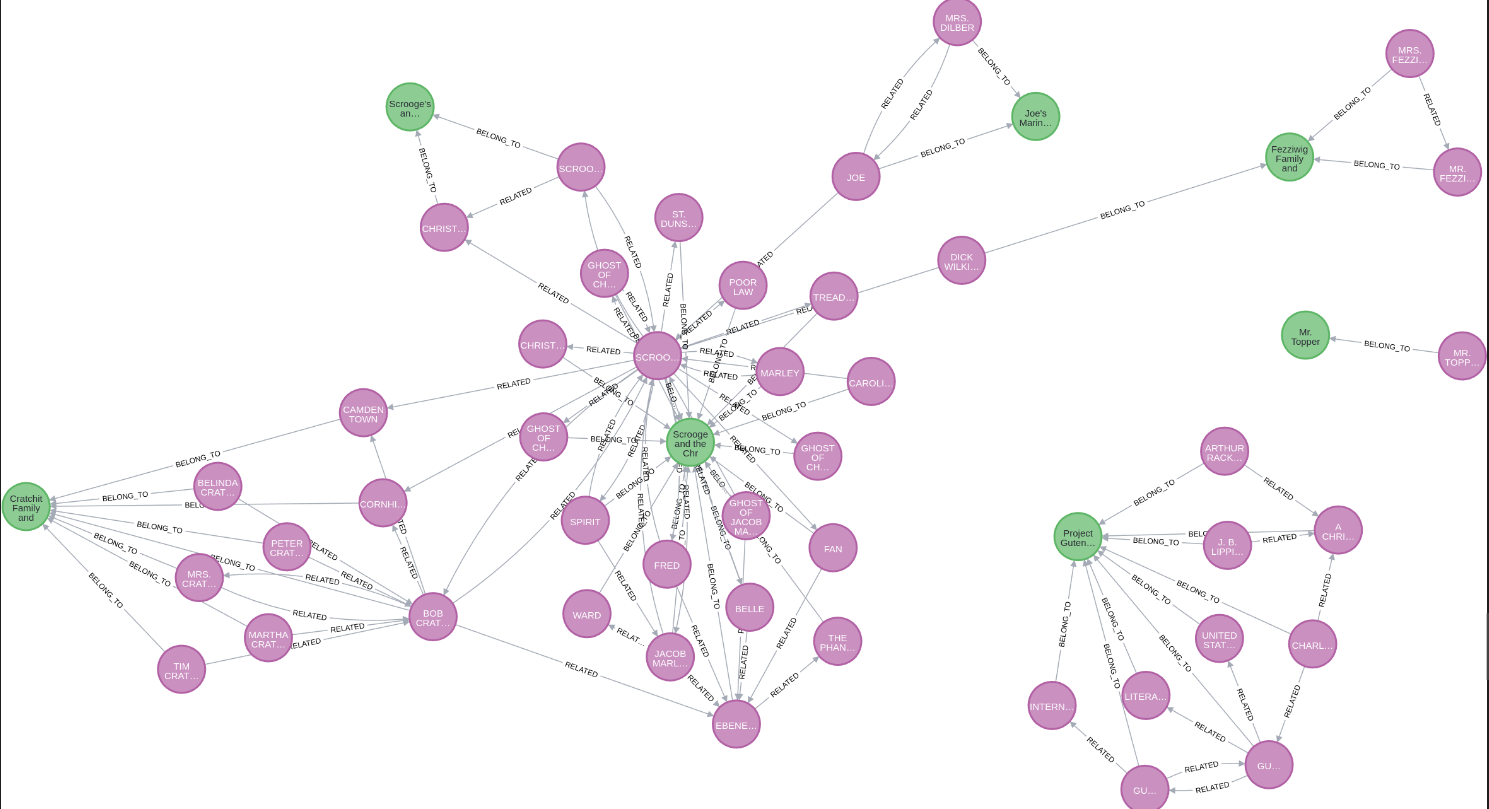

- The green nodes present community nodes, while the purple nodes present entity nodes.

- The entity node and community node have **BELONG_TO** relationship

In [61]:
query = f"""
DROP INDEX community_summary
"""

kg.query(query)

[]

In [62]:
query = """
CREATE VECTOR INDEX community_summary IF NOT EXISTS
FOR (c:Community)
ON (c.embedding)
OPTIONS { indexConfig: {
    `vector.dimensions`: 768,
    `vector.similarity_function`: 'cosine'    
}
}
"""

kg.query(query)

[]

## 6 Community Summaries -> Community Answers -> Global Answer

Whenever user enter a query, we will find the community whose summary close to query. For each close community, LLM will generate community answer base on that community summary. 

After that LLM will generate Global Answer base on list of community answers

In [3]:
from EmbeddingModel import GeminiEmbeddingModel
import cypher_query as cq
importlib.reload(cq)

gem = GeminiEmbeddingModel()
vector_index = "community_summary"

In [4]:
from prompts import global_answer_prompts, community_answer_prompts
from LLM import GeminiModel
import time

llm = GeminiModel()

In [14]:
user_query = "Who is Ebenezer Scrooge in Christmas Carol"


embedding_query = gem.embed(user_query)
communities = cq.get_search_result(kg, vector_index, 20, embedding_query)

In [15]:
communities[0]

["Scrooge's Transformation",
 'This community revolves around Ebenezer Scrooge, a miserly man who is visited by a series of ghosts that lead him on a journey of self-discovery and redemption. The ghosts represent different aspects of his life, including his past, present, and future. Through these encounters, Scrooge learns the importance of kindness, generosity, and the true spirit of Christmas. He ultimately changes his ways, becoming a kinder and more generous person. ',
 7.0,
 "The impact severity rating is high due to the story's focus on moral transformation and the potential for Scrooge's change to inspire others.",
 '[{"summary": "Scrooge\'s initial character and beliefs", "explanation": "Ebenezer Scrooge is the central figure in this community, and his initial character is defined by his miserliness, cynicism, and disdain for Christmas. He is shown to be a cold and unsympathetic man who values money above all else.  Scrooge\'s beliefs are challenged by the ghosts he encounters

In [17]:
# go through every community information and store list of answers
answers = []

for community in communities:
    summary, findings = community[1], community[4]
    prompt = community_answer_prompts.get_prompts(user_query, [summary, findings])
    time.sleep(5)
    
    try:
        answer = llm.generate(prompt)
    except:
        continue

    # gap between each request to prevent 429 error from google client
    

    # Filter answer
    if answer.find("<UNKNOWN>") != -1:
        continue

    answers.append(answer)

In [18]:
answers

["Ebenezer Scrooge is the main character in the story. He is known for his miserly and cynical personality. He is initially portrayed as a cold and unsympathetic person who values money above all else. Scrooge's beliefs and actions are challenged by the ghosts he encounters, who show him the consequences of his actions and the importance of generosity and compassion.  These ghosts represent different aspects of his life, including his past, present, and future. His transformation throughout the story is significant because it highlights the power of redemption and the possibility for change, even in someone who has been hardened by years of miserliness. \n",
 "Ebenezer Scrooge is the main character in the story, known for his miserly nature and his dislike of Christmas. He is portrayed as a grumpy and solitary man who contrasts with the joyful and generous spirit of his nephew and his family.  Scrooge's transformation throughout the story is driven by encounters with the Ghosts of Chri

In [24]:
# Using LLM to generate global answer based on list of answer
prompt = global_answer_prompts.get_prompts(answers)
global_answer = llm.generate(prompt)

print(global_answer)

Ebenezer Scrooge, the central figure in Charles Dickens's "A Christmas Carol," is a miserly and cynical character renowned for his disdain for Christmas. His initial portrayal as a cold and unsympathetic individual contrasts sharply with the joyful spirit of his nephew and the community. Scrooge's transformation throughout the story is attributed to his encounters with the Ghosts of Christmas Past, Present, and Future, who reveal the consequences of his actions and emphasize the importance of kindness and compassion. These ghosts represent various aspects of his life, including his past, present, and future. One particularly impactful encounter is with the Ghost of Christmas Present, who showcases the spirit of the holiday and how Scrooge's actions affect others. His relationship with Bob Cratchit, his employee, highlights the potential for exploitation and vulnerability within the community. Scrooge's miserliness contributes to the Cratchit family's financial struggles, particularly e